# CNNs for image classification on CIFAR-10 dataset

In [1]:
#importing relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

C:\Users\Administrator\miniconda3\envs\NLP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#creating training and test sets and converting each image to tensor


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

In [3]:
#Number of images in training and test set

print(len(training_data))
len(test_data)


50000


10000

In [4]:
#loading the first image of the training set
img=training_data[0][0]
print(img.shape)

torch.Size([3, 32, 32])


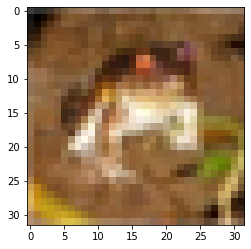

In [5]:
#displaying the image
plt.imshow(img.permute(1,2,0))

##### As the image is extremely pixelated, it is very hard for even a human to classify the contents of the image

In [6]:
def train_val_split(idxs, val_pct=0.1,seed=42):
    """Function that returns indices for 
    train set and validation set"""
    
    val_items=int(idxs*val_pct)
    np.random.seed(seed)
    randomized_indices=np.random.permutation(idxs)
    
    return randomized_indices[val_items:],randomized_indices[:val_items]

In [7]:
train_indices,val_indices=train_val_split(len(training_data))

In [8]:
#Sampler and DataLoader for train set
train_sampler=SubsetRandomSampler(train_indices)
train_dataLoader=DataLoader(training_data,batch_size=100,sampler=train_sampler)


#Sampler and DataLoader for validation set
valid_sampler=SubsetRandomSampler(val_indices)
val_dataLoader=DataLoader(training_data,batch_size=100,sampler=valid_sampler)

In [9]:
#showing 10 images from the training set 

from torchvision.utils import make_grid

def show_batch(dl):
    """ Create a grid of 10 images from the first batch of training dataloader """
    
    for xb,_ in dl:
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(xb,10).permute(1,2,0))
        break

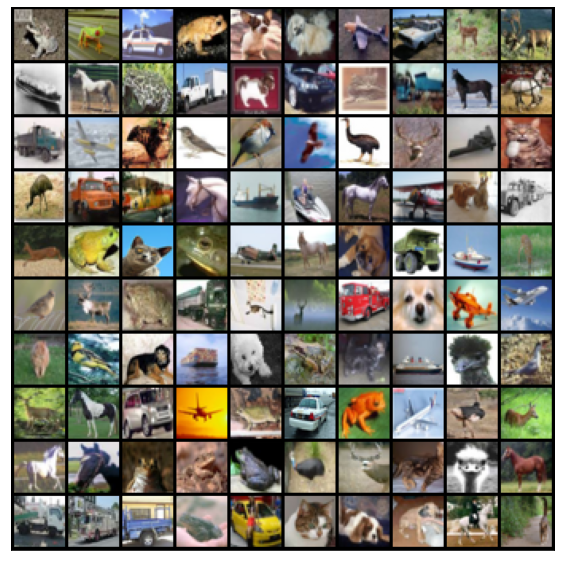

In [10]:
show_batch(train_dataLoader)

#### Instantiating a Convolutional Neural Network with 5 conv layers and 1 fully connected layer

In [11]:
CIFAR_10_model= nn.Sequential(
                
                nn.Conv2d(3,16,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2), # output dimension=bs x 16 x 16 x 16
    
                nn.Conv2d(16,32,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2), # output dimension= bs x 32 x 8 x 8
    
                nn.Conv2d(32,64,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2), # output dimension= bs x 64 x 4 x 4
    
                nn.Conv2d(64,128,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2), # output dimension= bs x 128 x 2 x 2
    
                nn.Conv2d(128,256,kernel_size=3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2), # output dimension= bs x 256 x 1 x 1
    
    
                nn.Flatten(), # output dimension= bs x 256
                
                nn.Linear(256,10) # output dimension= bs x 10
    
                )

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [13]:
device=get_default_device()
train_loader=DeviceDataLoader(train_dataLoader,device)
valid_loader=DeviceDataLoader(val_dataLoader,device)
to_device(CIFAR_10_model,device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=256, out_features=10, bias=True)
)

In [14]:
def accuracy(out,labels):
    
    """Metric for calculating correct classifcations"""
    
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
def calc_loss_batch_step(model, loss_fn, xb, yb, metric, optimizer=None):
    
    """Function for calculating loss and if optimizer is provided, perform the training step """
    
    preds=model(xb)
    loss=loss_fn(preds,yb)
    if optimizer is not None:
        
        #calculating gradient
        loss.backward()
        
        #gradient step
        optimizer.step()
        
        #clearing gradients
        optimizer.zero_grad()
        
    metric_results=metric(preds,yb)
    
    
    return loss.item(),len(xb),metric_results
        
        

In [16]:
def fit(epochs, lr, model,loss_func, train_loader, val_loader, metric, opt_func):
    
    """Generic fit function for training and evaluation loops"""
    
    opt=opt_func(model.parameters(),lr=lr)
    
    
    for i in tqdm(range(epochs)):
        train_losses_per_batch=[]
        #training loop
        model.train()
        for xb,yb in train_loader:
            loss,_,_=calc_loss_batch_step(model, loss_func, xb, yb, metric, opt)
            train_losses_per_batch.append(loss)
        train_loss_for_epoch=sum(train_losses_per_batch)/len(train_losses_per_batch)   
            
        #evaluation loop
        model.eval()
        result=evaluate(model, loss_func, val_loader, metric)
        val_loss, val_metric=result
        
        #progress report
        print("Epoch {}/{}".format(i+1,epochs))
        print("Train_Loss={}".format(train_loss_for_epoch))
        print("Validation_loss={}".format(val_loss))
        print("Validation Accuracy={}".format(val_metric))
            
        
    

In [17]:
def evaluate(model, loss_func, val_loader, metric):
    """Evaluation on validation set"""

    with torch.no_grad():
        results=[calc_loss_batch_step(model, loss_func, xb, yb, metric=metric) for xb,yb in val_loader]
        
        val_losses, nums, val_metrics=zip(*results)
        total_size=np.sum(nums)
        avg_loss=np.sum(np.multiply(val_losses,nums))/total_size
        avg_metric=np.sum(np.multiply(val_metrics,nums))/total_size
        
        return avg_loss,avg_metric
        
            

#### Evaluating untrained model

In [18]:
evaluate(CIFAR_10_model,loss_func=F.cross_entropy,val_loader=valid_loader,metric=accuracy)

(2.303729729652405, 0.09699999995529651)

In [19]:
#setting hyperparameters
num_epochs=10
learning_rate=0.005
optimizer=torch.optim.Adam


In [20]:
#fit
fit(num_epochs,learning_rate,CIFAR_10_model,F.cross_entropy,train_loader,valid_loader,accuracy,optimizer)

 10%|████████▏                                                                         | 1/10 [02:02<18:26, 122.98s/it]

Epoch 1/10
Train_Loss=1.747212573422326
Validation_loss=1.4691771602630614
Validation Accuracy=0.4597999995946884


 20%|████████████████▍                                                                 | 2/10 [04:18<17:22, 130.26s/it]

Epoch 2/10
Train_Loss=1.385541452831692
Validation_loss=1.297859628200531
Validation Accuracy=0.5257999986410141


 30%|████████████████████████▌                                                         | 3/10 [06:24<14:59, 128.45s/it]

Epoch 3/10
Train_Loss=1.2216853663656446
Validation_loss=1.1736421251296998
Validation Accuracy=0.5761999964714051


 40%|████████████████████████████████▊                                                 | 4/10 [08:39<13:05, 130.99s/it]

Epoch 4/10
Train_Loss=1.0982649302482606
Validation_loss=1.0541622149944305
Validation Accuracy=0.6173999977111816


 50%|█████████████████████████████████████████                                         | 5/10 [10:47<10:50, 130.08s/it]

Epoch 5/10
Train_Loss=0.9848651647567749
Validation_loss=1.0434112775325775
Validation Accuracy=0.6251999998092651


 60%|█████████████████████████████████████████████████▏                                | 6/10 [12:56<08:37, 129.49s/it]

Epoch 6/10
Train_Loss=0.8944453170564439
Validation_loss=0.9915772306919098
Validation Accuracy=0.6386000061035156


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [15:14<06:36, 132.16s/it]

Epoch 7/10
Train_Loss=0.8245912312136756
Validation_loss=0.8933208477497101
Validation Accuracy=0.6764000046253205


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [17:27<04:25, 132.59s/it]

Epoch 8/10
Train_Loss=0.7498107063770294
Validation_loss=0.8624821197986603
Validation Accuracy=0.6964000010490418


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [19:38<02:12, 132.15s/it]

Epoch 9/10
Train_Loss=0.6920129725005891
Validation_loss=0.8490441930294037
Validation Accuracy=0.6969999992847442


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [22:36<00:00, 135.67s/it]

Epoch 10/10
Train_Loss=0.6403671913014518
Validation_loss=0.8273328804969787
Validation Accuracy=0.7040000033378601


#### Future To-do for better performance

1) Use grid-search to find learning rate, and other hyperparameters (log results)
2) add more layers to the model (use different architectures)
